In [5]:
import numpy as np 
import pandas as pd 
import tensorflow as tf


**Importing the dataset for named entity recognition model**

In [6]:
data = pd.read_csv(r"E:\New Practical\Data Files\patterns sentences final tokenized.csv", encoding="utf8")
data = data.fillna(method="ffill")
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence 0,<left>,LEFT,B-left
1,Sentence 0,(+)-Norpseudoephedrine,TEST,B-test
2,Sentence 0,<space>,SPACE,B-space
3,Sentence 0,<num>,VALUE,B-value
4,Sentence 0,<space>,SPACE,B-space
5,Sentence 0,%,UNIT,B-unit
6,Sentence 0,fat,UNIT,I-unit
7,Sentence 0,<space>,SPACE,B-space
8,Sentence 0,<num>,REF,B-ref
9,Sentence 0,-,REF,I-ref


> **Create list of list of tuples to differentiate each sentence from each other**

In [7]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                       
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [9]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 100


In [10]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

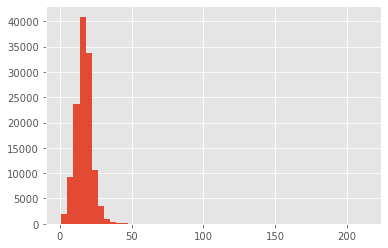

In [11]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [12]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words); n_words

37241

In [13]:
tags = list(set(data["Tag"].values))
n_tags = len(tags); n_tags

14

**Converting words to numbers and numbers to words**

In [14]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=100, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=100, sequences=y, padding="post", value=tag2idx["O"])

In [16]:
from tensorflow.keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3,shuffle = True)

In [18]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [19]:
input = Input(shape=(maxlen,))
model = Embedding(input_dim=n_words, output_dim=maxlen,
                  input_length=maxlen, mask_zero=True)(input) 
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)  
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)
model = Model(input, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 100)          3724100   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 200)          160800    
_________________________________________________________________
time_distributed (TimeDistri (None, 100, 14)           2814      
Total params: 3,887,714
Trainable params: 3,887,714
Non-trainable params: 0
_________________________________________________________________


In [20]:
# model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=['accuracy'])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [21]:
history = model.fit(x_train, np.array(y_train), batch_size=32, epochs=2, validation_split=0.1, verbose=1)

Epoch 1/2
2467/2467 [==============================] - 1027s 413ms/step - loss: 0.0385 - accuracy: 0.9903 - val_loss: 1.7082e-04 - val_accuracy: 1.0000
Epoch 2/2
2467/2467 [==============================] - 1079s 437ms/step - loss: 9.7561e-05 - accuracy: 1.0000 - val_loss: 5.9936e-05 - val_accuracy: 1.0000


In [22]:
model.save('lab_bilstm_model_adam_30p_tokenized_100.h5')

In [23]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(x_test[i],p[0]):
#     print("{:15}: {}".format(words[w],tags[pred]))
    print("{:15}: {}".format(words[w],tags[pred]))

Word            (True ): Pred
<left>         : B-left
Steiner        : B-test
silver         : I-test
stain          : I-test
method         : I-test
(procedure)    : I-test
<space>        : B-space
<num>          : B-value
<space>        : B-space
1012           : B-unit
L−1            : I-unit
<space>        : B-space
<num>          : B-ref
-              : I-ref
<num>          : I-ref
<line>         : B-line
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         : O
ENDPAD         

In [24]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
test_pred = model.predict(x_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

1175/1175 [==============================] - 102s 86ms/step


In [26]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [27]:
print("Precision: {:.2%}".format(precision_score(test_labels, pred_labels)))
print("Recall: {:.2%}".format(recall_score(test_labels, pred_labels)))
print("F1-score: {:.2%}".format(f1_score(test_labels, pred_labels)))

Precision: 99.97%
Recall: 99.97%
F1-score: 99.97%
